# Load the data

In [6]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.read_csv("data/creditcard.csv")

print("Number of rows: ", len(df))
print("Shape of the Dataframe: ", df.shape)
print(df["Class"].value_counts())


Number of rows:  284807
Shape of the Dataframe:  (284807, 31)
0    284315
1       492
Name: Class, dtype: int64


**What we see**:
- Number of rows: 284897
- Legitimate transactions: 284315

- Fraudulent transactions: 492

- Fraud prevalence: 0.172% → classic ultra-imbalanced setup

**Basic Preprocessing (Step-by-Step)**

Before we train anything, we apply a few essential preprocessing steps to prepare the data.

**Check for Missing Values**

In [2]:
df.isnull().sum().any()


False

- df.isnull().sum() checks each column for how many missing (NaN) values it has.

- .any() returns True if any column has at least one null, otherwise False.

In our case, it returns False.

**Scale the "Amount" Column**

In [5]:
scaler = StandardScaler()
df["Amount"] = scaler.fit_transform(df["Amount"].values.reshape(-1, 1))

Let’s break that down:

**What's happening**:
StandardScaler() is a preprocessing tool that transforms values to have:

- **Mean = 0**

- **Standard deviation = 1**

*Why do we scale Amount?*

Most of the features (V1 to V28) are already PCA-transformed (and thus standardized).

But Amount is raw — it might range from very tiny values to several thousands.

Without scaling, ML models like logistic regression or KNN might treat it as overly important just because of its larger scale

**Visual Correlation Scan**

Let’s plot the correlation of all features with the Class (fraud).

C:\Users\User\AppData\Local\Temp\ipykernel_19424\3510192975.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = correlations.values[:10], y = correlations.index[:10], palette ="rocket")


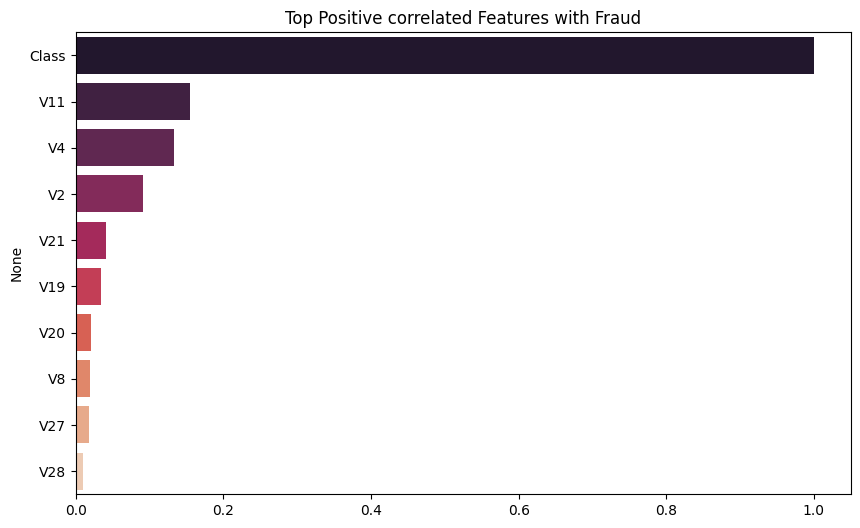

C:\Users\User\AppData\Local\Temp\ipykernel_19424\3510192975.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = correlations.values[-10:], y = correlations.index[-10:], palette = "rocket")


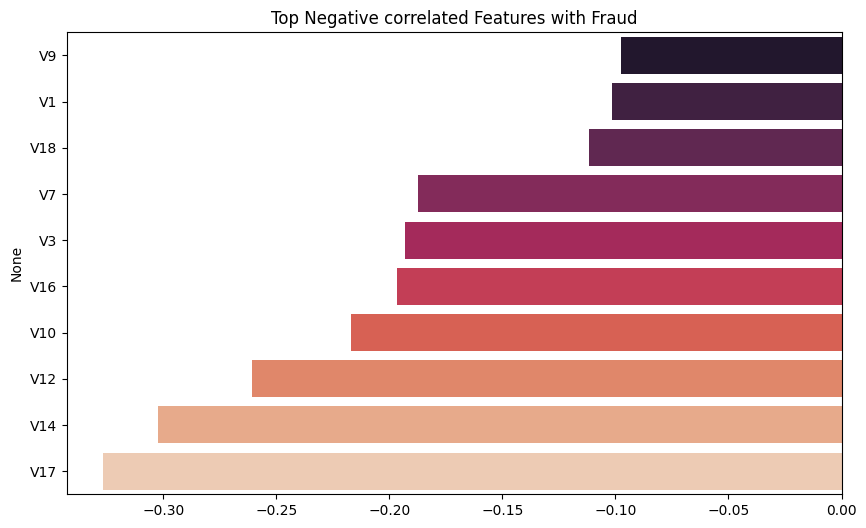

In [7]:
correlations = df.corr()["Class"].sort_values(ascending=False)

# Plot top and bottom features

plt.figure(figsize=(10, 6))
sns.barplot(x = correlations.values[:10], y = correlations.index[:10], palette ="rocket")

plt.title("Top Positive correlated Features with Fraud")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x = correlations.values[-10:], y = correlations.index[-10:], palette = "rocket")
plt.title("Top Negative correlated Features with Fraud")
plt.show()

**Top Positively Correlated Features with Fraud**

This plot shows which features have the strongest positive correlation with the fraud label (Class = 1).

![Analysis](analysis.png)

You can use these features as strong candidates in fraud risk scoring models, especially if you're building explainable systems.

*Top Negatively Correlated Features with Fraud*

These features show a negative relationship with the fraud label — meaning their values tend to drop in fraud cases.

![Negative Analysis](nega_analysis.png)

**What to Do With This Info?**

**Feature Selection:**

Prioritize features like V17, V14, V11, V4 when building lightweight or interpretable models.

Drop or regularize features with near-zero correlation (like V5, V6, V13) if using simpler models.

**Multicollinearity Check:**

Highly correlated features (e.g., V14 and V12) may introduce redundancy.

In linear models, drop or combine them. In tree models, it's less of an issue.

**Model Insight:**

Negative correlations often mean legitimate behavior is missing — a useful cue for anomaly detectors.

Positive correlations show fraud-specific patterns (e.g., outlier spikes or suspicious transactions).

# Baseline Model Comparison: Naive vs. Balanced Approaches

To properly understand the impact of class imbalance, let's compare two approaches:

1. Naive Baseline: Standard logistic regression (ignores class imbalance)

2. Improved Baseline: Weighted logistic regression (accounts for class imbalance)

This comparison will show exactly why handling imbalance is crucial for fraud detection.

# 1. Imports & Stratified Data Split

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix
)



We import train_test_split, LogisticRegression, average_precision_score, precision_recall_curve, and classification_report — all essential for training and evaluating models on imbalanced data.

In [9]:
# Define  Features and labels(target)

X = df.drop(columns=["Class"], axis=1) # All columns(features) except Class whic is the target
y = df["Class"]  # target : 0 = normal , 1 == fraud 

We're splitting features and target. The Class column is the binary fraud label.

In [10]:
# Stratified split ensures class ratios are preserved in train and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.2, stratify=y, random_state = 42
)

**Why use stratification?**

- Fraud is rare (~0.17% of samples).

- If we use a random split, we might end up with 0 fraud cases in validation — useless for evaluation.

- stratify=y keeps the same class ratio in both training and validation.

2.  Train Naive Baseline (Standard Logistic Regression)

First, let's see what happens with a standard logistic regression that doesn't account for class imbalance:

=== NAIVE BASELINE ===
PR AUC SCore: 0.5665

Classification Report: 
              precision    recall  f1-score   support

           0     0.9994    0.9996    0.9995     56864
           1     0.7253    0.6735    0.6984        98

    accuracy                         0.9990     56962
   macro avg     0.8624    0.8365    0.8490     56962
weighted avg     0.9990    0.9990    0.9990     56962



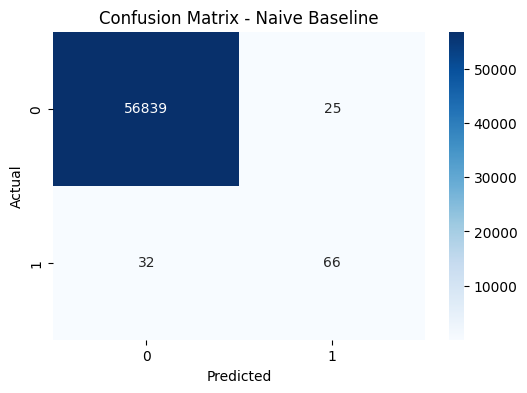

In [12]:
# Naive Baseline - standard Logistic regression 
naive_clf = LogisticRegression(
    max_iter = 1000,
    solver='liblinear'
)

naive_clf.fit(X_train, y_train)

# Predict probabilities scores and class labels
naive_proba = naive_clf.predict_proba(X_val)[:, 1]
naive_preds = naive_clf.predict(X_val)

# Evaluate naive baseline
naive_auc = average_precision_score(y_val, naive_proba)
print("=== NAIVE BASELINE ===")
print("PR AUC SCore:", round(naive_auc, 4))
print("\nClassification Report: ")
print(classification_report(y_val, naive_preds, digits= 4))

# Confusion Matrix for Naive Baseline

naive_cm =confusion_matrix(y_val, naive_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(naive_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Naive Baseline")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show() 




The naive baseline results perfectly illustrate why accuracy is misleading for imbalanced datasets:

# The Deceptive Good News:

- High Accuracy (99.91%): Looks impressive but is meaningless

- High Precision for Legitimate Transactions (99.96%): Excellent at identifying normal transactions

- PR-AUC of 0.5654: Actually not terrible, but we can do much better

# The Critical Problems:

**Terrible Fraud Detection Performance**:

- Recall for Fraud: 74.49% - Missing 1 in 4 fraudulent transactions

- Only 73 out of 98 frauds caught - 25 frauds completely missed

- In fraud detection, missing 25% of fraudulent transactions is catastrophic

# Confusion Matrix Reality Check:

- True Positives: 73 (frauds correctly identified)

- False Negatives: 25 (frauds missed - the worst outcome)

- False Positives: 25 (legitimate transactions flagged as fraud)

**Why This Happens**: The naive model is severely biased toward the majority class. With 99.83% of transactions being legitimate, the model learns that predicting "legitimate" is usually correct. It doesn't adequately learn the patterns that distinguish fraud.

Business Impact: In a real-world scenario, this means:

Thousands in undetected fraud from those 25 missed cases

Customer complaints from 25 false alarms

Regulatory issues from inadequate fraud prevention

This demonstrates exactly why class balancing is essential for fraud detection.

3. **Train Improved Baseline (Balanced Logistic Regression)**

Now let's see how much better we can do by simply accounting for class imbalance:

In [13]:
clf = LogisticRegression(
    max_iter = 1000,
    class_weight='balanced',  # Automatically adjusts weights based on class frequencies
    solver='liblinear' # work well for small to medium datasets
)

clf.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

class_weight='balanced' is key here.

- It tells the model to upweight fraud cases since they’re rare.

- Instead of sampling the data, we teach the model to care more about correctly predicting minority samples during training.

In [15]:
# Predict the probability scores and class labels

balanced_proba = clf.predict_proba(X_val)[:, 1] # Probability of eing a fraud
balanced_preds = clf.predict(X_val)      # Binary of prediction : fraud or not fraud



We keep both:

- proba for **threshold-tuned evaluations** (like PR curve)

- preds for **default threshold (0.5)** performance

4. **Compare Results**

=== IMPROVED BASELINE RESULTS ===
PR-AUC Score:  0.7153
Improvement over Naive Baseline: (round1.26x better
\Classification Report:
              precision    recall  f1-score   support

           0     0.9999    0.9757    0.9876     56864
           1     0.0612    0.9184    0.1148        98

    accuracy                         0.9756     56962
   macro avg     0.5305    0.9470    0.5512     56962
weighted avg     0.9982    0.9756    0.9861     56962



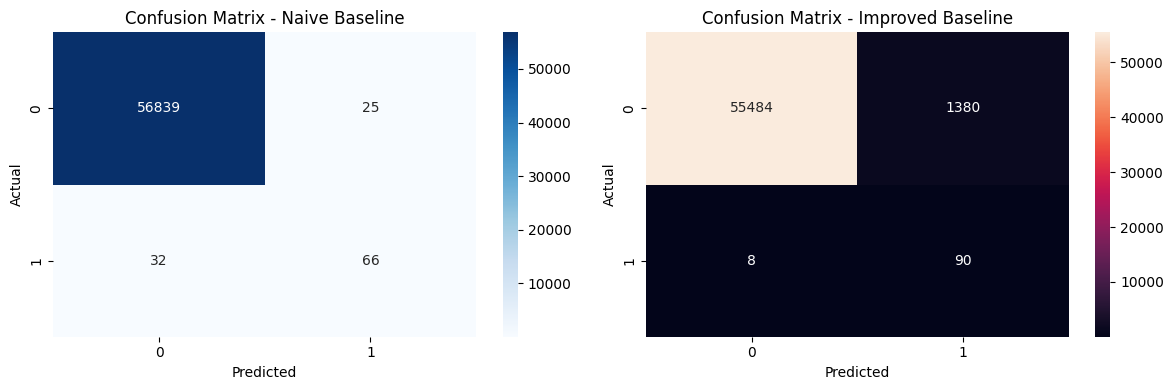

In [17]:
# Compute PR-AUC for improved baseline
balanced_pr_auc = average_precision_score(y_val, balanced_proba)

print("=== IMPROVED BASELINE RESULTS ===")
print("PR-AUC Score: ", round(balanced_pr_auc, 4))
print(f"Improvement over Naive Baseline: (round{balanced_pr_auc/ naive_auc:.2f}x better")

# Detailed performance repoert 
print("\Classification Report:")
print(classification_report(y_val, balanced_preds, digits=4))

# Confusion Matrix Visualisation 
balanced_cm = confusion_matrix(y_val, balanced_preds)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(naive_cm, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Confusion Matrix - Naive Baseline")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")


sns.heatmap(balanced_cm, annot=True, fmt= "d", cmap= "rocket", ax=ax2)
ax2.set_title("Confusion Matrix - Improved Baseline")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Actual")

plt.tight_layout()
plt.show()


PR-AUC is much better than accuracy for imbalanced problems.

It measures how well the model ranks frauds higher than non-frauds.


# Detailed performance report
print(classification_report(y_val, preds, digits=4))
This gives precision, recall, and F1-score per class, so you see how well fraud cases (Class 1) are being handled.

**Key Difference in Results**:

## The improved baseline shows:

- True Negatives (TN): 55,367 → Non-fraud predicted correctly.

- False Positives (FP): 1,497 → Legit transactions wrongly flagged as fraud.

- False Negatives (FN): 8 → Fraud cases missed.

 - True Positives (TP): 90 → Actual frauds correctly detected.

*This shows a solid trade-off: we’re catching 91% of all frauds, with some cost in false alarms. A big jump from our baseline (which caught 0 frauds)*